In [1]:
import openml
import pandas as pd
import numpy as np
import random
from abc import ABC

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

from jenga.basis import BinaryClassificationTask
from jenga.corruptions.generic import MissingValues, SwappedValues
from jenga.corruptions.numerical import Scaling

import datawig

This is a "work in progress" notebook. The goal is to have a set of functions with only 3 user inputs:
* dataset_name
* learner: the estimator to be used
* param_grid: the parameter names as keys and lists of param settings to try as values

## Dataset

In [2]:
def get_alldata(dataset_name):
    ''' Get dataset from the OpenML Datasets and tranform it for use.
    
    Params:
    dataset_name: str: name of the dataset
    
    Returns:
    all_data: dataframe: combined data and labels
    attribute_names: list: names of attributes from the data
    attribute_types: dataframe: names and types of attributes from the data 
    '''
    
    data = openml.datasets.get_dataset(dataset_name)
    
    ## summary
    print(f"Dataset '{data.name}', target: '{data.default_target_attribute}'")
    print(data.description[:500])
    
    ## load the data
    # X: An array/dataframe where each row represents one example with the corresponding feature values
    # y: the classes for each example
    # categorical_indicator - an array that indicates which feature is categorical
    # attribute_names - the names of the features for the examples(X) and target feature (y)
    X, y, categorical_indicator, attribute_names = data.get_data(
        dataset_format='dataframe',
        target=data.default_target_attribute
    )
    
    ## combine the attribute names with the information of them being categorical or not
    # will be used further in order not to manually distinguish between the numerical and categorical features
    attribute_types = pd.DataFrame(attribute_names, columns=["attribute_names"])
    attribute_types['categorical_indicator'] = categorical_indicator
    print("\nAttribute types: ")
    display(attribute_types)
    
    all_data = X.copy(deep=True)
    all_data['class'] = y
    
    return all_data, attribute_names, attribute_types

In [3]:
## test credit-g dataset (openML)
all_data, attribute_names, attribute_types = get_alldata("credit-g")
print(attribute_names)
display(all_data.head())

Dataset 'credit-g', target: 'class'
**Author**: Dr. Hans Hofmann  

**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    

**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)



**German Credit data**  

This dataset classifies people described by a set of attributes as good or bad credit risks.



This dataset comes with a cost matrix: 

``` 

      Good  Bad (predicted)  

Good   0    1   (actual)  

Bad    5    0  

```



It is worse to class a customer as go

Attribute types: 


,attribute_names,categorical_indicator
0,checking_status,True
1,duration,False
2,credit_history,True
3,purpose,True
4,credit_amount,False
5,savings_status,True
6,employment,True
7,installment_commitment,False
8,personal_status,True
9,other_parties,True


['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


### Visualize the dataset

In [4]:
## plot the original dataset
def hide_current_axis(*args, **kwds):
        plt.gca().set_visible(False)
        
def plot_data(data):
    sns.set_style("white") # grid/no grid style: darkgrid, whitegrid, dark, white, ticks
    
    plot = sns.pairplot(data, hue="class")
    plot.map_upper(hide_current_axis)
    plt.show()

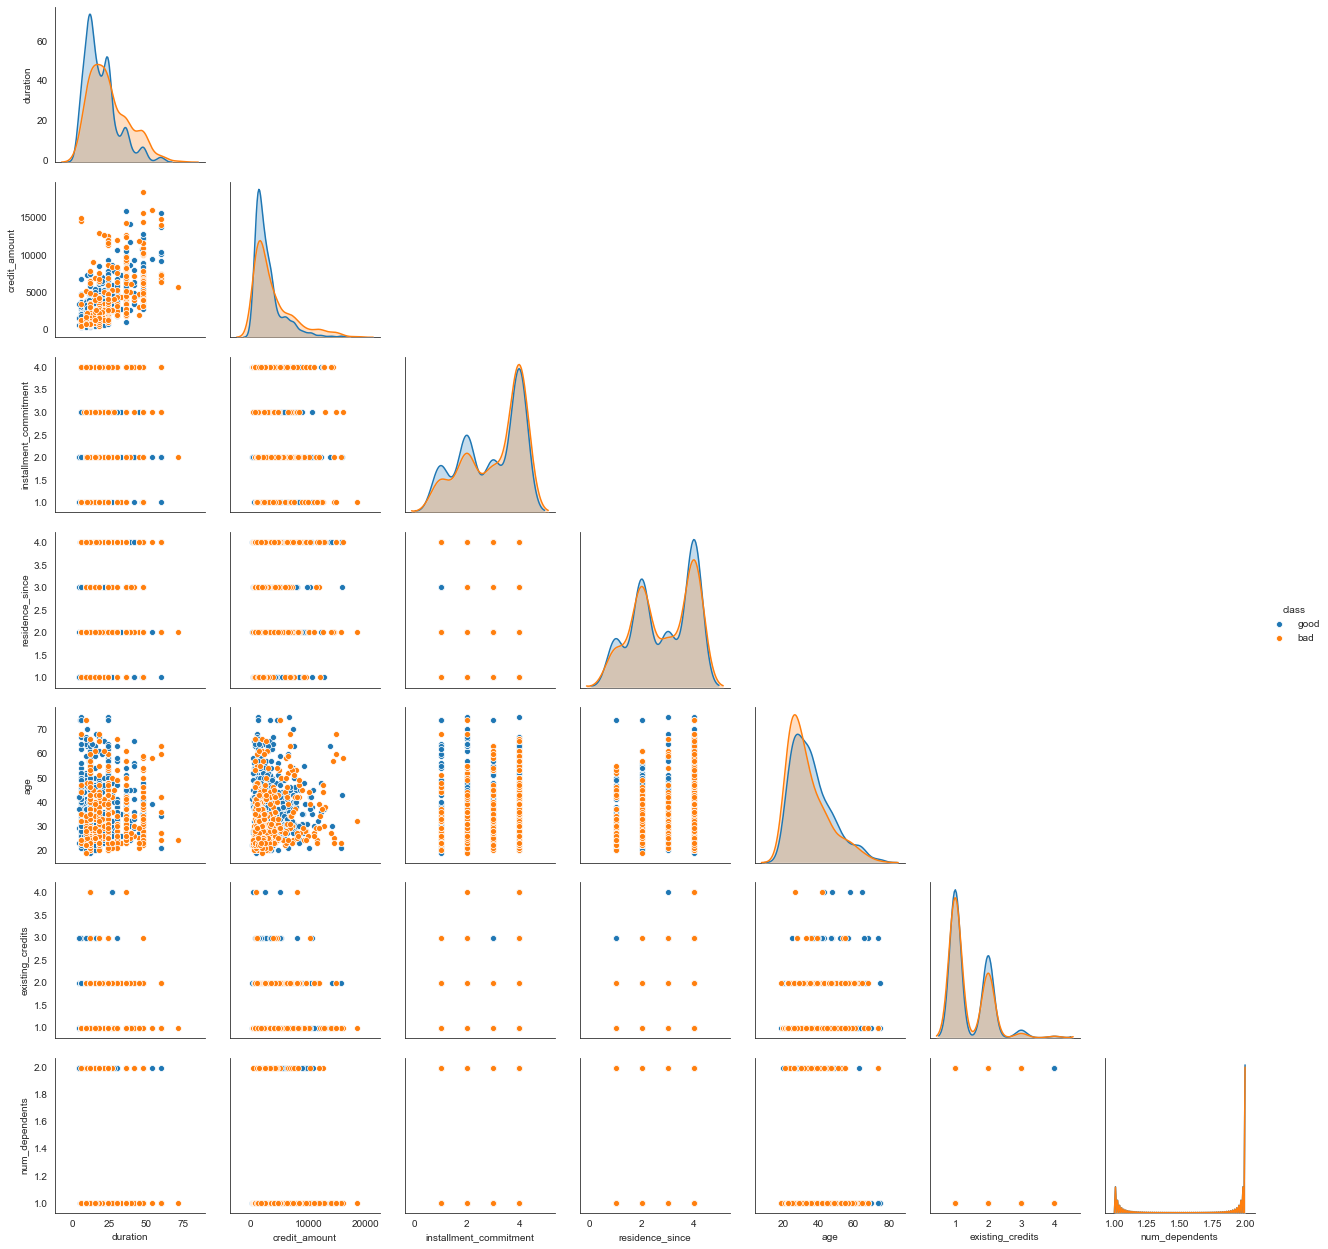

In [5]:
plot_data(all_data)

### Get training and test sets

In [6]:
def get_train_test_data(all_data, attribute_names):
    ''' Get train and test data along with train and test labels.
    
    Params:
    all_data: dataframe: combined data and labels
    attribute_names: list: names of attributes from the data
    
    Returns:
    train_data: dataframe:
    train_labels: list
    test_data: dataframe
    test_labels: list
    '''
    
    train_split, test_split = train_test_split(all_data, test_size=0.2)
    
    train_data = train_split[attribute_names]
    train_labels = np.array(train_split['class'])
    
    test_data = test_split[attribute_names]
    test_labels = np.array(test_split['class'])
    
    return train_data, train_labels, test_data, test_labels

In [7]:
## test credit-g dataset (openML)
train_data, train_labels, test_data, test_labels = get_train_test_data(all_data, attribute_names)

display(train_data.head())
print(train_labels[0:5])

display(test_data.head())
print(test_labels[0:5])

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,<0,60.0,delayed previously,business,6836.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes
557,no checking,21.0,no credits/all paid,new car,5003.0,no known savings,1<=X<4,1.0,female div/dep/mar,none,4.0,life insurance,29.0,bank,own,2.0,skilled,1.0,yes,yes
836,no checking,12.0,existing paid,radio/tv,886.0,no known savings,1<=X<4,4.0,female div/dep/mar,none,2.0,car,21.0,none,own,1.0,skilled,1.0,none,yes


['bad' 'bad' 'good' 'bad' 'good']


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
737,<0,18.0,existing paid,new car,4380.0,100<=X<500,1<=X<4,3.0,male single,none,4.0,car,35.0,none,own,1.0,unskilled resident,2.0,yes,yes
740,<0,24.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,none,3.0,car,32.0,bank,own,1.0,skilled,1.0,none,yes
660,>=200,12.0,existing paid,radio/tv,1297.0,<100,1<=X<4,3.0,male mar/wid,none,4.0,real estate,23.0,none,rent,1.0,skilled,1.0,none,yes
411,no checking,33.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,none,2.0,car,35.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes


['bad' 'good' 'good' 'good' 'good']


In [ ]:
## good
import numpy as np
import random
import pandas as pd
import openml

from sklearn.model_selection import train_test_split


class Dataset:
    def __init__(self, seed, dataset_name):
        
        ## fix random seeds for reproducibility
        random.seed(seed)
        np.random.seed(seed)
        
        
        data = openml.datasets.get_dataset(dataset_name)
        
        ## summary
        print(f"Dataset '{data.name}', target: '{data.default_target_attribute}'")
        print(data.description[:500])
        
        ## load the data
        # X: An array/dataframe where each row represents one example with the corresponding feature values
        # y: the classes for each example
        # categorical_indicator - an array that indicates which feature is categorical
        # attribute_names - the names of the features for the examples(X) and target feature (y)
        X, y, categorical_indicator, self.attribute_names = data.get_data(
            dataset_format='dataframe',
            target=data.default_target_attribute
        )
        
        ## combine the attribute names with the information of them being categorical or not
        # will be used further in order not to manually distinguish between the numerical and categorical features
        self.attribute_types = pd.DataFrame(self.attribute_names, columns=["attribute_names"])
        self.attribute_types['categorical_indicator'] = categorical_indicator
        print("\nAttribute types: ")
        display(self.attribute_types)

        self.all_data = X.copy(deep=True)
        self.all_data['class'] = y
        
    
    def get_train_test_data(self):
        ''' Get train and test data along with train and test labels.

        Params:
        all_data: dataframe: combined data and labels
        attribute_names: list: names of attributes from the data

        Returns:
        train_data: dataframe:
        train_labels: list
        test_data: dataframe
        test_labels: list
        '''

        train_split, test_split = train_test_split(self.all_data, test_size=0.2)

        train_data = train_split[self.attribute_names]
        train_labels = np.array(train_split['class'])

        test_data = test_split[self.attribute_names]
        test_labels = np.array(test_split['class'])

        return train_data, train_labels, test_data, test_labels

## Model

In [8]:
def fit_model(train_data, train_labels, attribute_types, learner, param_grid):
    ''' Get a trained model.
    
    Params:
    train_data: dataframe
    train_labels: list
    attribute_types: dataframe: names and types of attributes from the data 
    learner: estimator object: estimator to be used
    param_grid: dict: param names as keys and lists of param settings to try as values
    
    Returns:
    categorical_columns
    numerical_columms
    model
    '''
    
    categorical_columns = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == True])
    numerical_columms = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == False])
    
    # preprocessing pipeline for numerical columns
    transformer_numeric = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('standard_scale', StandardScaler())
    ])
    
    # preprocessing pipeline for categorical columns
    transformer_categorical = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='__NA__')),
        ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # preprocessor
    feature_transform = ColumnTransformer(transformers=[
        ('categorical_features', transformer_categorical, categorical_columns),
        ('numerical_features', transformer_numeric, numerical_columms)
    ])
    
    ## prediction pipeline: append classifier (learner) to the preprocessing pipeline
    pipeline = Pipeline([
        ('features', feature_transform),
        ('learner', learner)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
    model = grid_search.fit(train_data, train_labels)
    
    return categorical_columns, numerical_columms, model    

In [9]:
categorical_columns, numerical_columms, model = fit_model(train_data, train_labels, attribute_types, 
                                                          learner=SGDClassifier(max_iter=1000), 
                                                          param_grid={
                                                              'learner__loss': ['log'],
                                                              'learner__penalty': ['l2', 'l1', 'elasticnet'],
                                                              'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
                                                          })

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   11.2s finished


In [10]:
categorical_columns

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

In [11]:
numerical_columms

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [ ]:
## good
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from jenga.basis import BinaryClassificationTask


class SimpleModel(BinaryClassificationTask):
    
    
    def __init__(self, seed, train_data, train_labels, test_data, test_labels, attribute_types, learner, param_grid):
        
        self.categorical_columns = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == True])
        self.numerical_columms = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == False])
        
        BinaryClassificationTask.__init__(self, seed, train_data, train_labels, test_data, test_labels, self.categorical_columns, self.numerical_columms)
        
        self.learner = learner
        self.param_grid = param_grid
        
    
    def fit_baseline_model(self, train_data, train_labels):
        
        ''' Get a trained model.
    
        Params:
        train_data: dataframe
        train_labels: list
        learner: estimator object: estimator to be used
        param_grid: dict: param names as keys and lists of param settings to try as values

        Returns:
        categorical_columns
        numerical_columms
        model
        '''
        
        # preprocessing pipeline for numerical columns
        transformer_numeric = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('standard_scale', StandardScaler())
        ])

        # preprocessing pipeline for categorical columns
        transformer_categorical = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='__NA__')),
            ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
        ])

        # preprocessor
        feature_transform = ColumnTransformer(transformers=[
            ('categorical_features', transformer_categorical, self.categorical_columns),
            ('numerical_features', transformer_numeric, self.numerical_columms)
        ])

        ## prediction pipeline: append classifier (learner) to the preprocessing pipeline
        pipeline = Pipeline([
            ('features', feature_transform),
            ('learner', self.learner)
        ])

        grid_search = GridSearchCV(pipeline, self.param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
        model = grid_search.fit(train_data, train_labels)

        return model  

## Corruptions

In [12]:
corruptions = {
    'missing': [MissingValues],
    'categorical': [SwappedValues],
    'numeric': [Scaling]
}

In [13]:
def random_perturbation(categorical_columns, numerical_columms, fractions=[0.25, 0.5, 0.75, 0.9]):
    ''' Get a random perturbation for a column, chosen from corruptions: missing, numeric, or categorical
    
    Params:
    categorical_columns: list
    numerical_columns: list
    fractions: list: fractions to select from for corruptions
    
    Returns:
    perturbation
    '''
    
    ## get a random perturbation type
    if len(categorical_columns) > 0 and len(numerical_columms) > 0:
        perturb_type = random.choice(list(corruptions.keys()))
    elif len(categorical_columns) > 0:
        perturb_type = 'categorical'
    elif len(numerical_columms) > 0:
        perturb_type = 'numeric'
    
    
    ## get perturbation on a random column based on the perturbation type
    ## update perturbation to random selection when more perturbation types are added to corruptions
    rand_fraction = random.choice(fractions)
    if perturb_type is 'numeric':
        col_to_perturb = random.choice(numerical_columms)
        return Scaling(col_to_perturb, rand_fraction), [col_to_perturb]
    elif perturb_type is 'categorical':
        col_to_perturb = random.sample(categorical_columns, 2)
        return SwappedValues(col_to_perturb[0], col_to_perturb[1], rand_fraction), col_to_perturb
    elif perturb_type is 'missing':
        missigness = random.choice(['MCAR', 'MAR', 'MNAR'])
        col_to_perturb = random.choice(numerical_columms + categorical_columns)
        #if col_to_perturb in categorical_columns:
        #    na_value = np.nan
        #else:
        #    na_value = 0
        na_value = np.nan
        return MissingValues(col_to_perturb, rand_fraction, na_value, missigness), [col_to_perturb]


In [14]:
def apply_perturbation(df, num_perturbations, categorical_columns, numerical_columms):
    df_corrupted = df.copy()
    
    perturbations = []
    cols_perturbed = []
    
    for _ in range(num_perturbations):
        perturbation, col_perturbed = random_perturbation(categorical_columns, numerical_columms)
        print(perturbation)
        print(col_perturbed)
        
        ## storing for conservation
        # maybe we want to apply the same set of perturbations again: useful for the CleanML scenarios
        # or maybe we want to reuse the columns that were perturbed
        perturbations.append(perturbation) 
        cols_perturbed.append(col_perturbed)
        
        df_corrupted = perturbation.transform(df_corrupted)
    
    ## cols_perturbed is a list of lists, flattening it here
    cols_perturbed = [col for sublist in cols_perturbed for col in sublist]
        
    return df_corrupted, perturbations, cols_perturbed

In [15]:
test_data_corrupted, perturbations, cols_perturbed = apply_perturbation(test_data, 5, categorical_columns, numerical_columms)
test_data_corrupted

SwappedValues: {'column_a': 'checking_status', 'column_b': 'employment', 'fraction': 0.9}
['checking_status', 'employment']
SwappedValues: {'column_a': 'checking_status', 'column_b': 'property_magnitude', 'fraction': 0.25}
['checking_status', 'property_magnitude']
SwappedValues: {'column_a': 'other_parties', 'column_b': 'foreign_worker', 'fraction': 0.9}
['other_parties', 'foreign_worker']
Scaling: {'column': 'duration', 'fraction': 0.25}
['duration']
MissingValues: {'column': 'job', 'fraction': 0.75, 'na_value': nan, 'missingness': 'MAR'}
['job']


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,yes,2.0,real estate,24.0,none,own,1.0,NaN,1.0,none,none
737,1<=X<4,180.0,existing paid,new car,4380.0,100<=X<500,<0,3.0,male single,yes,4.0,car,35.0,none,own,1.0,NaN,2.0,yes,none
740,car,240.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,yes,3.0,<0,32.0,bank,own,1.0,NaN,1.0,none,none
660,1<=X<4,120.0,existing paid,radio/tv,1297.0,<100,>=200,3.0,male mar/wid,yes,4.0,real estate,23.0,none,rent,1.0,NaN,1.0,none,none
411,no checking,330.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,yes,2.0,car,35.0,none,own,2.0,NaN,1.0,yes,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,>=7,240.0,existing paid,radio/tv,3235.0,500<=X<1000,no checking,3.0,male div/sep,yes,2.0,car,26.0,none,own,1.0,NaN,1.0,yes,none
332,<1,60.0,existing paid,new car,7408.0,100<=X<500,0<=X<200,4.0,female div/dep/mar,yes,2.0,life insurance,24.0,none,own,1.0,NaN,1.0,none,none
208,1<=X<4,24.0,existing paid,business,6568.0,<100,<0,2.0,male mar/wid,yes,2.0,car,21.0,stores,own,1.0,NaN,1.0,none,none
613,1<=X<4,24.0,all paid,used car,3632.0,<100,<0,1.0,female div/dep/mar,no,4.0,car,22.0,bank,rent,1.0,NaN,1.0,none,guarantor


In [16]:
perturbations

In [17]:
cols_perturbed

['checking_status',
 'employment',
 'checking_status',
 'property_magnitude',
 'other_parties',
 'foreign_worker',
 'duration',
 'job']

In [ ]:
## good
import random
import numpy as np

from jenga.corruptions.generic import MissingValues, SwappedValues
from jenga.corruptions.numerical import Scaling


DEFAULT_CORRUPTIONS = {
    'missing': [MissingValues],
    'categorical': [SwappedValues],
    'numeric': [Scaling]
}

DEFAULT_FRACTIONS = [0.25, 0.5, 0.75]


class Perturbation:
    
    
    def __init__(self, categorical_columns, numerical_columms, corruptions=DEFAULT_CORRUPTIONS, fractions=DEFAULT_FRACTIONS):
        self.categorical_columns = categorical_columns
        self.numerical_columms = numerical_columms
        self.corruptions = corruptions
        self.fractions = fractions
        
    
    def random_perturbation(self, categorical_columns, numerical_columms):
        ''' Get a random perturbation for a column, chosen from corruptions: missing, numeric, or categorical
    
        Params:
        categorical_columns: list
        numerical_columns: list
        fractions: list: fractions to select from for corruptions

        Returns:
        perturbation
        '''
        
        ## get a random perturbation type
        if len(self.categorical_columns) > 0 and len(self.numerical_columms) > 0:
            perturb_type = random.choice(list(self.corruptions.keys()))
        elif len(self.categorical_columns) > 0:
            perturb_type = 'categorical'
        elif len(self.numerical_columms) > 0:
            perturb_type = 'numeric'


        ## get perturbation on a random column based on the perturbation type
        ## update perturbation to random selection when more perturbation types are added to corruptions
        rand_fraction = random.choice(self.fractions)
        if perturb_type is 'numeric':
            col_to_perturb = random.choice(self.numerical_columms)
            return Scaling(col_to_perturb, rand_fraction), [col_to_perturb]
        elif perturb_type is 'categorical':
            col_to_perturb = random.sample(self.categorical_columns, 2)
            return SwappedValues(col_to_perturb[0], col_to_perturb[1], rand_fraction), col_to_perturb
        elif perturb_type is 'missing':
            missigness = random.choice(['MCAR', 'MAR', 'MNAR'])
            col_to_perturb = random.choice(self.numerical_columms + self.categorical_columns)
            na_value = np.nan
            return MissingValues(col_to_perturb, rand_fraction, na_value, missigness), [col_to_perturb]
        
    
    def apply_perturbation(self, df, num_perturbations):
        df_corrupted = df.copy()
    
        perturbations = []
        cols_perturbed = []

        for _ in range(num_perturbations):
            perturbation, col_perturbed = self.random_perturbation(self.categorical_columns, self.numerical_columms)
            print(perturbation)
            print(col_perturbed)

            ## storing for conservation
            # maybe we want to apply the same set of perturbations again: useful for the CleanML scenarios
            # or maybe we want to reuse the columns that were perturbed
            perturbations.append(perturbation) 
            cols_perturbed.append(col_perturbed)

            df_corrupted = perturbation.transform(df_corrupted)

        ## cols_perturbed is a list of lists, flattening it here
        cols_perturbed = [col for sublist in cols_perturbed for col in sublist]

        return df_corrupted, perturbations, cols_perturbed

### Visualize the original and corrupted test set

D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


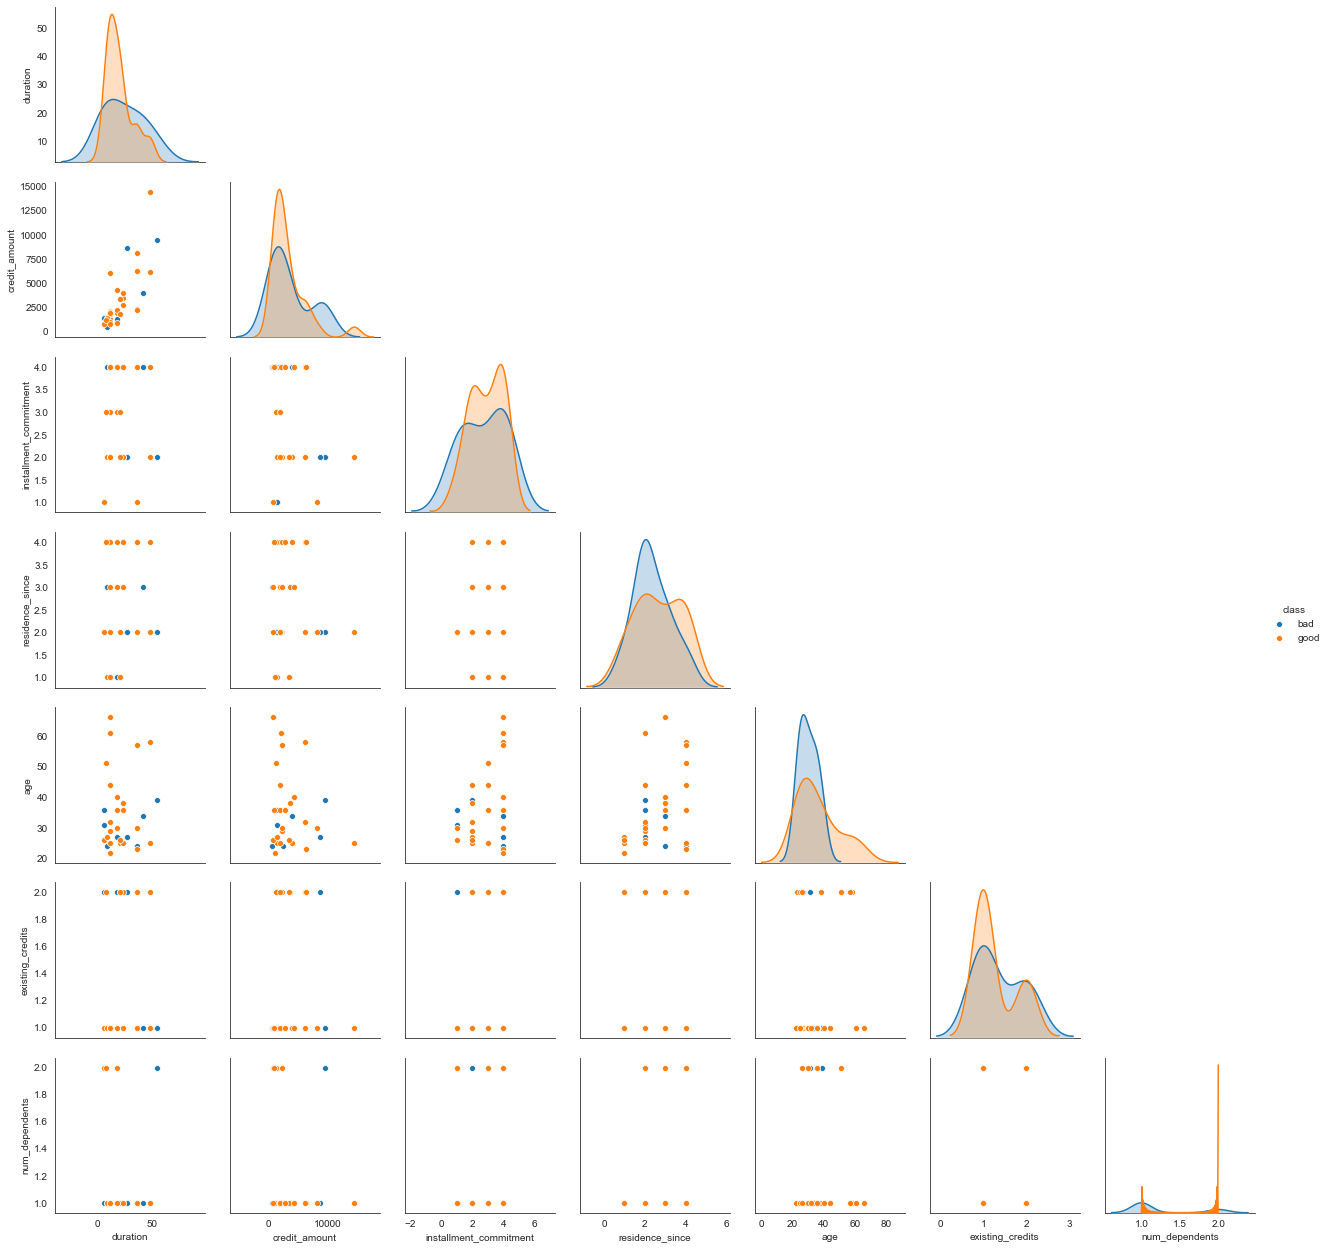

In [18]:
## original test data
plot_data(pd.concat([test_data, pd.Series(test_labels, name='class')], axis=1))

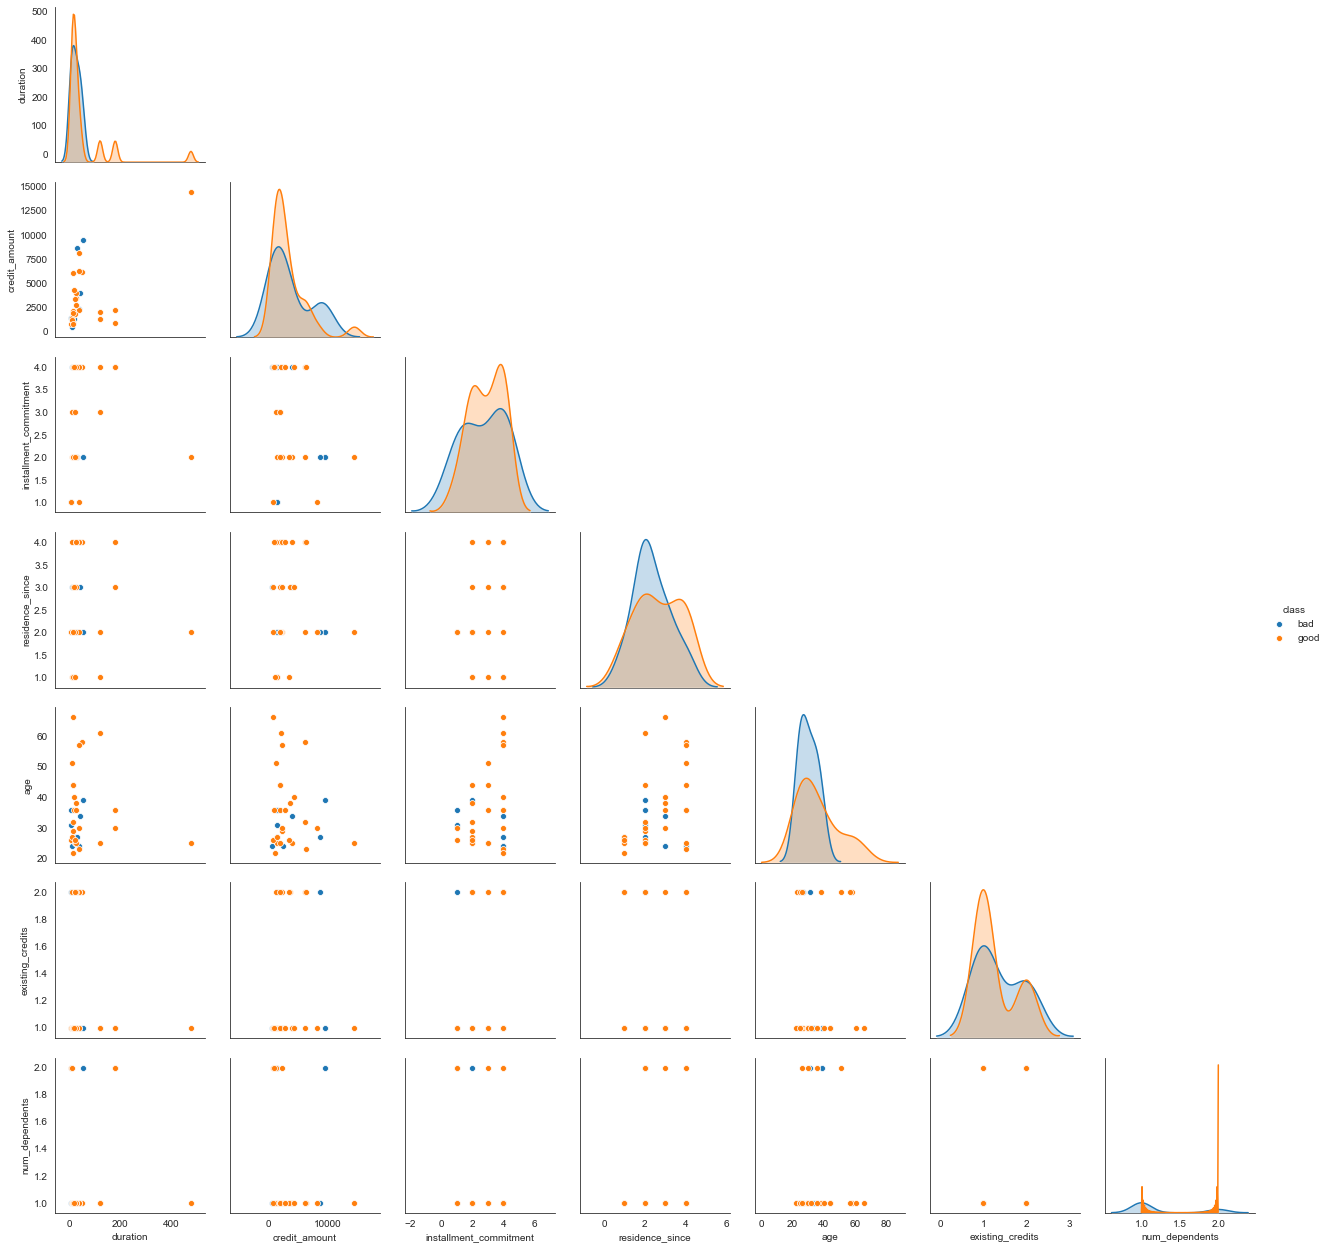

In [19]:
## corrupted test data
plot_data(pd.concat([test_data_corrupted, pd.Series(test_labels, name='class')], axis=1))

## Cleaning

### Imputation

#### Missing Data

##### Mean/Mode Imputation

In [20]:
def mean_mode_imputer(df_corrupted, df, numerical_columms, categorical_columns):
    df_cleaned = df_corrupted.copy()
    cols_with_na = df_cleaned.columns[df_cleaned.isnull().any()].tolist()
    
    for col in cols_with_na:
        if col in numerical_columms:
            # mean imputer
            df_cleaned.loc[df_cleaned[col].isnull(), col] = np.mean(df[col])
        elif col in categorical_columns:
            # mode imputer
            df_cleaned.loc[df_cleaned[col].isnull(), col] = df[col].value_counts().index[0]
            
    return df_cleaned

In [66]:
test_data_mm_cleaned = mean_mode_imputer(test_data_corrupted, numerical_columms, categorical_columns)
test_data_mm_cleaned

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,yes,2.0,real estate,24.0,none,own,1.0,nan,1.0,none,none
737,1<=X<4,180.0,existing paid,new car,4380.0,100<=X<500,<0,3.0,male single,yes,4.0,car,35.0,none,own,1.0,nan,2.0,yes,none
740,car,240.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,yes,3.0,<0,32.0,bank,own,1.0,nan,1.0,none,none
660,1<=X<4,120.0,existing paid,radio/tv,1297.0,<100,>=200,3.0,male mar/wid,yes,4.0,real estate,23.0,none,rent,1.0,nan,1.0,none,none
411,no checking,330.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,yes,2.0,car,35.0,none,own,2.0,nan,1.0,yes,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,>=7,240.0,existing paid,radio/tv,3235.0,500<=X<1000,no checking,3.0,male div/sep,yes,2.0,car,26.0,none,own,1.0,nan,1.0,yes,none
332,<1,60.0,existing paid,new car,7408.0,100<=X<500,0<=X<200,4.0,female div/dep/mar,yes,2.0,life insurance,24.0,none,own,1.0,nan,1.0,none,none
208,1<=X<4,24.0,existing paid,business,6568.0,<100,<0,2.0,male mar/wid,yes,2.0,car,21.0,stores,own,1.0,nan,1.0,none,none
613,1<=X<4,24.0,all paid,used car,3632.0,<100,<0,1.0,female div/dep/mar,no,4.0,car,22.0,bank,rent,1.0,nan,1.0,none,guarantor


##### Datawig Imputation

In [22]:
def datawig_imputer(df_train, df_corrupted, cols_perturbed, categorical_columns, numerical_columms):
    df_cleaned = df_corrupted.copy()
    #cols_with_na = df_cleaned.columns[df_cleaned.isnull().any()].tolist()
    
    for col in df_train.columns:
        if pd.api.types.is_categorical_dtype(df_train[col]):
            df_train[col] = df_train[col].astype(str)
            
    for col in df_corrupted.columns:
        if pd.api.types.is_categorical_dtype(df_corrupted[col]):
            df_corrupted[col] = df_corrupted[col].astype(str)
    
    
    for col in cols_perturbed:
        output_column = col
        input_columns = list(set(df_corrupted.columns) - set([output_column]))
        
        print(f"Fitting model for column: {col}")
        imputer = datawig.SimpleImputer(input_columns, output_column, 'imputer_model')
        imputer.fit(df_train)
        
        df_cleaned = imputer.predict(df_cleaned)
        df_cleaned.loc[df_cleaned[col].isnull(), col] = df_cleaned[col + '_imputed']
        df_cleaned = df_cleaned[df_corrupted.columns]
        
    return df_cleaned

In [68]:
test_data_dw_cleaned = datawig_imputer(test_data_corrupted, categorical_columns, numerical_columms)
test_data_dw_cleaned

Fitting model for column: checking_status


2020-06-18 23:09:03,800 [INFO]  CategoricalEncoder for column checking_status                                found only 42 occurrences of value 1<=X<4
2020-06-18 23:09:03,905 [INFO]  CategoricalEncoder for column checking_status                                found only 35 occurrences of value >=7
2020-06-18 23:09:03,937 [INFO]  CategoricalEncoder for column checking_status                                found only 22 occurrences of value <1
2020-06-18 23:09:03,942 [INFO]  CategoricalEncoder for column checking_status                                found only 19 occurrences of value 4<=X<7
2020-06-18 23:09:03,946 [INFO]  CategoricalEncoder for column checking_status                                found only 14 occurrences of value car
2020-06-18 23:09:03,951 [INFO]  CategoricalEncoder for column checking_status                                found only 11 occurrences of value real estate
2020-06-18 23:09:03,973 [INFO]  CategoricalEncoder for column checking_status                      

Fitting model for column: credit_history


2020-06-18 23:09:17,155 [WARNING]  Test set does not contain any ocurrences of values [no credits/all paid] in column [credit_history], consider using a more representative test set.
2020-06-18 23:09:17,174 [INFO]  
========== start: fit model
2020-06-18 23:09:17,179 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:09:17,485 [INFO]  Epoch[0] Batch [0-6]	Speed: 422.18 samples/sec	cross-entropy=1.399825	credit_history-accuracy=0.482143
2020-06-18 23:09:17,666 [INFO]  Epoch[0] Train-cross-entropy=1.214510
2020-06-18 23:09:17,672 [INFO]  Epoch[0] Train-credit_history-accuracy=0.531250
2020-06-18 23:09:17,677 [INFO]  Epoch[0] Time cost=0.490
2020-06-18 23:09:17,695 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:09:17,763 [INFO]  Epoch[0] Validation-cross-entropy=1.785404
2020-06-18 23:09:17,768 [INFO]  Epoch[0] Validation-credit_history-accuracy=0.343750
2020-06-18 23:09:18,046 [INFO]  Epoch[1] Batch [0-6]	Speed: 417.52 samples/sec	cross-entropy=0.921687	

Fitting model for column: purpose


2020-06-18 23:09:27,094 [WARNING]  Test set does not contain any ocurrences of values [business, education, repairs, retraining] in column [purpose], consider using a more representative test set.
2020-06-18 23:09:27,111 [INFO]  
========== start: fit model
2020-06-18 23:09:27,116 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:09:27,474 [INFO]  Epoch[0] Batch [0-6]	Speed: 370.90 samples/sec	cross-entropy=1.937344	purpose-accuracy=0.169643
2020-06-18 23:09:27,689 [INFO]  Epoch[0] Train-cross-entropy=1.846633
2020-06-18 23:09:27,694 [INFO]  Epoch[0] Train-purpose-accuracy=0.197917
2020-06-18 23:09:27,699 [INFO]  Epoch[0] Time cost=0.566
2020-06-18 23:09:27,723 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:09:27,795 [INFO]  Epoch[0] Validation-cross-entropy=1.712241
2020-06-18 23:09:27,799 [INFO]  Epoch[0] Validation-purpose-accuracy=0.250000
2020-06-18 23:09:28,050 [INFO]  Epoch[1] Batch [0-6]	Speed: 465.01 samples/sec	cross-entropy=1.564814	purpose

Fitting model for column: savings_status


2020-06-18 23:09:57,618 [INFO]  
========== start: fit model
2020-06-18 23:09:57,625 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:09:57,949 [INFO]  Epoch[0] Batch [0-6]	Speed: 424.04 samples/sec	cross-entropy=1.320310	savings_status-accuracy=0.616071
2020-06-18 23:09:58,132 [INFO]  Epoch[0] Train-cross-entropy=1.341650
2020-06-18 23:09:58,138 [INFO]  Epoch[0] Train-savings_status-accuracy=0.578125
2020-06-18 23:09:58,146 [INFO]  Epoch[0] Time cost=0.479
2020-06-18 23:09:58,165 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:09:58,228 [INFO]  Epoch[0] Validation-cross-entropy=2.351538
2020-06-18 23:09:58,233 [INFO]  Epoch[0] Validation-savings_status-accuracy=0.375000
2020-06-18 23:09:58,466 [INFO]  Epoch[1] Batch [0-6]	Speed: 483.70 samples/sec	cross-entropy=0.913874	savings_status-accuracy=0.669643
2020-06-18 23:09:58,620 [INFO]  Epoch[1] Train-cross-entropy=1.015761
2020-06-18 23:09:58,625 [INFO]  Epoch[1] Train-savings_status-accuracy=0.609375


Fitting model for column: employment


2020-06-18 23:10:04,024 [WARNING]  Test set does not contain any ocurrences of values [4<=X<7, >=7, <1] in column [employment], consider using a more representative test set.
2020-06-18 23:10:04,043 [INFO]  
========== start: fit model
2020-06-18 23:10:04,048 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:10:04,347 [INFO]  Epoch[0] Batch [0-6]	Speed: 458.36 samples/sec	cross-entropy=1.761991	employment-accuracy=0.232143
2020-06-18 23:10:04,520 [INFO]  Epoch[0] Train-cross-entropy=1.692843
2020-06-18 23:10:04,525 [INFO]  Epoch[0] Train-employment-accuracy=0.286458
2020-06-18 23:10:04,531 [INFO]  Epoch[0] Time cost=0.475
2020-06-18 23:10:04,550 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:10:04,602 [INFO]  Epoch[0] Validation-cross-entropy=1.208787
2020-06-18 23:10:04,607 [INFO]  Epoch[0] Validation-employment-accuracy=0.625000
2020-06-18 23:10:04,844 [INFO]  Epoch[1] Batch [0-6]	Speed: 513.60 samples/sec	cross-entropy=1.351026	employment-accuracy=

Fitting model for column: personal_status


2020-06-18 23:10:11,992 [INFO]  
========== start: fit model
2020-06-18 23:10:11,997 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:10:12,250 [INFO]  Epoch[0] Batch [0-6]	Speed: 525.99 samples/sec	cross-entropy=1.256730	personal_status-accuracy=0.482143
2020-06-18 23:10:12,429 [INFO]  Epoch[0] Train-cross-entropy=1.129886
2020-06-18 23:10:12,434 [INFO]  Epoch[0] Train-personal_status-accuracy=0.552083
2020-06-18 23:10:12,439 [INFO]  Epoch[0] Time cost=0.432
2020-06-18 23:10:12,454 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:10:12,518 [INFO]  Epoch[0] Validation-cross-entropy=0.777690
2020-06-18 23:10:12,526 [INFO]  Epoch[0] Validation-personal_status-accuracy=0.750000
2020-06-18 23:10:12,742 [INFO]  Epoch[1] Batch [0-6]	Speed: 534.76 samples/sec	cross-entropy=1.064663	personal_status-accuracy=0.508929
2020-06-18 23:10:12,909 [INFO]  Epoch[1] Train-cross-entropy=0.986332
2020-06-18 23:10:12,916 [INFO]  Epoch[1] Train-personal_status-accuracy=0.56

2020-06-18 23:10:19,915 [INFO]  Epoch[13] Validation-cross-entropy=0.642032
2020-06-18 23:10:19,922 [INFO]  Epoch[13] Validation-personal_status-accuracy=0.718750
2020-06-18 23:10:20,175 [INFO]  Epoch[14] Batch [0-6]	Speed: 454.04 samples/sec	cross-entropy=0.608571	personal_status-accuracy=0.776786
2020-06-18 23:10:20,328 [INFO]  Epoch[14] Train-cross-entropy=0.600985
2020-06-18 23:10:20,333 [INFO]  Epoch[14] Train-personal_status-accuracy=0.776042
2020-06-18 23:10:20,338 [INFO]  Epoch[14] Time cost=0.411
2020-06-18 23:10:20,353 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2020-06-18 23:10:20,407 [INFO]  Epoch[14] Validation-cross-entropy=0.634647
2020-06-18 23:10:20,414 [INFO]  Epoch[14] Validation-personal_status-accuracy=0.718750
2020-06-18 23:10:20,643 [INFO]  Epoch[15] Batch [0-6]	Speed: 506.61 samples/sec	cross-entropy=0.590541	personal_status-accuracy=0.785714
2020-06-18 23:10:20,806 [INFO]  Epoch[15] Train-cross-entropy=0.585249
2020-06-18 23:10:20,811 [INFO]  

2020-06-18 23:10:27,703 [INFO]  Epoch[27] Time cost=0.472
2020-06-18 23:10:27,726 [INFO]  Saved checkpoint to "imputer_model\model-0027.params"
2020-06-18 23:10:27,791 [INFO]  Epoch[27] Validation-cross-entropy=0.563753
2020-06-18 23:10:27,796 [INFO]  Epoch[27] Validation-personal_status-accuracy=0.718750
2020-06-18 23:10:28,076 [INFO]  Epoch[28] Batch [0-6]	Speed: 466.11 samples/sec	cross-entropy=0.417548	personal_status-accuracy=0.866071
2020-06-18 23:10:28,219 [INFO]  Epoch[28] Train-cross-entropy=0.425752
2020-06-18 23:10:28,225 [INFO]  Epoch[28] Train-personal_status-accuracy=0.838542
2020-06-18 23:10:28,234 [INFO]  Epoch[28] Time cost=0.431
2020-06-18 23:10:28,248 [INFO]  Saved checkpoint to "imputer_model\model-0028.params"
2020-06-18 23:10:28,314 [INFO]  Epoch[28] Validation-cross-entropy=0.561391
2020-06-18 23:10:28,319 [INFO]  Epoch[28] Validation-personal_status-accuracy=0.718750
2020-06-18 23:10:28,547 [INFO]  Epoch[29] Batch [0-6]	Speed: 526.00 samples/sec	cross-entropy=0.

2020-06-18 23:10:35,670 [INFO]  Epoch[41] Train-cross-entropy=0.328026
2020-06-18 23:10:35,675 [INFO]  Epoch[41] Train-personal_status-accuracy=0.895833
2020-06-18 23:10:35,681 [INFO]  Epoch[41] Time cost=0.422
2020-06-18 23:10:35,743 [INFO]  Saved checkpoint to "imputer_model\model-0041.params"
2020-06-18 23:10:35,795 [INFO]  Epoch[41] Validation-cross-entropy=0.546163
2020-06-18 23:10:35,802 [INFO]  Epoch[41] Validation-personal_status-accuracy=0.718750
2020-06-18 23:10:36,058 [INFO]  Epoch[42] Batch [0-6]	Speed: 465.01 samples/sec	cross-entropy=0.311877	personal_status-accuracy=0.910714
2020-06-18 23:10:36,233 [INFO]  Epoch[42] Train-cross-entropy=0.322266
2020-06-18 23:10:36,237 [INFO]  Epoch[42] Train-personal_status-accuracy=0.901042
2020-06-18 23:10:36,243 [INFO]  Epoch[42] Time cost=0.436
2020-06-18 23:10:36,259 [INFO]  Saved checkpoint to "imputer_model\model-0042.params"
2020-06-18 23:10:36,319 [INFO]  Epoch[42] Validation-cross-entropy=0.548281
2020-06-18 23:10:36,324 [INFO]

Fitting model for column: other_parties


2020-06-18 23:10:41,694 [WARNING]  Test set does not contain any ocurrences of values [co applicant] in column [other_parties], consider using a more representative test set.
2020-06-18 23:10:41,769 [INFO]  
========== start: fit model
2020-06-18 23:10:41,775 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:10:42,107 [INFO]  Epoch[0] Batch [0-6]	Speed: 397.76 samples/sec	cross-entropy=0.999449	other_parties-accuracy=0.750000
2020-06-18 23:10:42,306 [INFO]  Epoch[0] Train-cross-entropy=0.796951
2020-06-18 23:10:42,316 [INFO]  Epoch[0] Train-other_parties-accuracy=0.807292
2020-06-18 23:10:42,323 [INFO]  Epoch[0] Time cost=0.539
2020-06-18 23:10:42,347 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:10:42,422 [INFO]  Epoch[0] Validation-cross-entropy=0.487850
2020-06-18 23:10:42,429 [INFO]  Epoch[0] Validation-other_parties-accuracy=0.875000
2020-06-18 23:10:42,702 [INFO]  Epoch[1] Batch [0-6]	Speed: 441.54 samples/sec	cross-entropy=0.649733	other_parti

2020-06-18 23:10:52,037 [INFO]  Epoch[13] Time cost=1.941
2020-06-18 23:10:52,097 [INFO]  Saved checkpoint to "imputer_model\model-0013.params"
2020-06-18 23:10:52,213 [INFO]  Epoch[13] Validation-cross-entropy=0.364690
2020-06-18 23:10:52,220 [INFO]  Epoch[13] Validation-other_parties-accuracy=0.875000
2020-06-18 23:10:52,628 [INFO]  Epoch[14] Batch [0-6]	Speed: 276.58 samples/sec	cross-entropy=0.309344	other_parties-accuracy=0.857143
2020-06-18 23:10:52,817 [INFO]  Epoch[14] Train-cross-entropy=0.272692
2020-06-18 23:10:52,824 [INFO]  Epoch[14] Train-other_parties-accuracy=0.880208
2020-06-18 23:10:52,829 [INFO]  Epoch[14] Time cost=0.601
2020-06-18 23:10:52,849 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2020-06-18 23:10:52,930 [INFO]  Epoch[14] Validation-cross-entropy=0.361708
2020-06-18 23:10:52,936 [INFO]  Epoch[14] Validation-other_parties-accuracy=0.875000
2020-06-18 23:10:53,238 [INFO]  Epoch[15] Batch [0-6]	Speed: 424.94 samples/sec	cross-entropy=0.296672	o

Fitting model for column: property_magnitude


2020-06-18 23:11:00,493 [WARNING]  Test set does not contain any ocurrences of values [4<=X<7, <0] in column [property_magnitude], consider using a more representative test set.
2020-06-18 23:11:00,514 [INFO]  
========== start: fit model
2020-06-18 23:11:00,520 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:11:01,196 [INFO]  Epoch[0] Batch [0-6]	Speed: 208.38 samples/sec	cross-entropy=2.043316	property_magnitude-accuracy=0.250000
2020-06-18 23:11:01,465 [INFO]  Epoch[0] Train-cross-entropy=1.998477
2020-06-18 23:11:01,470 [INFO]  Epoch[0] Train-property_magnitude-accuracy=0.234375
2020-06-18 23:11:01,475 [INFO]  Epoch[0] Time cost=0.929
2020-06-18 23:11:01,502 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:11:01,560 [INFO]  Epoch[0] Validation-cross-entropy=1.764350
2020-06-18 23:11:01,566 [INFO]  Epoch[0] Validation-property_magnitude-accuracy=0.218750
2020-06-18 23:11:01,858 [INFO]  Epoch[1] Batch [0-6]	Speed: 392.89 samples/sec	cross-entropy=1.

Fitting model for column: other_payment_plans


2020-06-18 23:11:09,725 [INFO]  
========== start: fit model
2020-06-18 23:11:09,730 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:11:09,995 [INFO]  Epoch[0] Batch [0-6]	Speed: 609.10 samples/sec	cross-entropy=0.958407	other_payment_plans-accuracy=0.678571
2020-06-18 23:11:10,130 [INFO]  Epoch[0] Train-cross-entropy=0.799341
2020-06-18 23:11:10,136 [INFO]  Epoch[0] Train-other_payment_plans-accuracy=0.750000
2020-06-18 23:11:10,145 [INFO]  Epoch[0] Time cost=0.403
2020-06-18 23:11:10,175 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:11:10,254 [INFO]  Epoch[0] Validation-cross-entropy=0.270638
2020-06-18 23:11:10,261 [INFO]  Epoch[0] Validation-other_payment_plans-accuracy=0.937500
2020-06-18 23:11:10,531 [INFO]  Epoch[1] Batch [0-6]	Speed: 498.74 samples/sec	cross-entropy=0.756264	other_payment_plans-accuracy=0.750000
2020-06-18 23:11:10,763 [INFO]  Epoch[1] Train-cross-entropy=0.660152
2020-06-18 23:11:10,770 [INFO]  Epoch[1] Train-other_payment

Fitting model for column: housing


2020-06-18 23:11:15,331 [INFO]  
========== start: fit model
2020-06-18 23:11:15,366 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:11:15,607 [INFO]  Epoch[0] Batch [0-6]	Speed: 523.13 samples/sec	cross-entropy=0.993676	housing-accuracy=0.651786
2020-06-18 23:11:15,853 [INFO]  Epoch[0] Train-cross-entropy=1.064116
2020-06-18 23:11:15,857 [INFO]  Epoch[0] Train-housing-accuracy=0.619792
2020-06-18 23:11:15,863 [INFO]  Epoch[0] Time cost=0.488
2020-06-18 23:11:16,049 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:11:16,098 [INFO]  Epoch[0] Validation-cross-entropy=0.559298
2020-06-18 23:11:16,103 [INFO]  Epoch[0] Validation-housing-accuracy=0.812500
2020-06-18 23:11:16,319 [INFO]  Epoch[1] Batch [0-6]	Speed: 532.84 samples/sec	cross-entropy=0.720209	housing-accuracy=0.714286
2020-06-18 23:11:16,463 [INFO]  Epoch[1] Train-cross-entropy=0.785956
2020-06-18 23:11:16,469 [INFO]  Epoch[1] Train-housing-accuracy=0.656250
2020-06-18 23:11:16,475 [INFO]  Epo

2020-06-18 23:11:22,328 [INFO]  Epoch[14] Train-cross-entropy=0.436851
2020-06-18 23:11:22,333 [INFO]  Epoch[14] Train-housing-accuracy=0.817708
2020-06-18 23:11:22,338 [INFO]  Epoch[14] Time cost=0.326
2020-06-18 23:11:22,353 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2020-06-18 23:11:22,403 [INFO]  Epoch[14] Validation-cross-entropy=0.417477
2020-06-18 23:11:22,409 [INFO]  Epoch[14] Validation-housing-accuracy=0.875000
2020-06-18 23:11:22,592 [INFO]  Epoch[15] Batch [0-6]	Speed: 659.29 samples/sec	cross-entropy=0.409719	housing-accuracy=0.821429
2020-06-18 23:11:22,732 [INFO]  Epoch[15] Train-cross-entropy=0.425487
2020-06-18 23:11:22,737 [INFO]  Epoch[15] Train-housing-accuracy=0.822917
2020-06-18 23:11:22,742 [INFO]  Epoch[15] Time cost=0.325
2020-06-18 23:11:22,759 [INFO]  Saved checkpoint to "imputer_model\model-0015.params"
2020-06-18 23:11:22,803 [INFO]  No improvement detected for 5 epochs compared to 0.4140043556690216 last error obtained: 0.419330567121505

Fitting model for column: job


2020-06-18 23:11:25,282 [WARNING]  Test set does not contain any ocurrences of values [unemp/unskilled non res] in column [job], consider using a more representative test set.
2020-06-18 23:11:25,298 [INFO]  
========== start: fit model
2020-06-18 23:11:25,303 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:11:25,563 [INFO]  Epoch[0] Batch [0-6]	Speed: 571.22 samples/sec	cross-entropy=1.186805	job-accuracy=0.714286
2020-06-18 23:11:25,704 [INFO]  Epoch[0] Train-cross-entropy=0.989522
2020-06-18 23:11:25,709 [INFO]  Epoch[0] Train-job-accuracy=0.755208
2020-06-18 23:11:25,715 [INFO]  Epoch[0] Time cost=0.401
2020-06-18 23:11:25,730 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:11:25,772 [INFO]  Epoch[0] Validation-cross-entropy=1.543822
2020-06-18 23:11:25,778 [INFO]  Epoch[0] Validation-job-accuracy=0.406250
2020-06-18 23:11:26,009 [INFO]  Epoch[1] Batch [0-6]	Speed: 488.61 samples/sec	cross-entropy=0.741933	job-accuracy=0.750000
2020-06-18 23:11:2

Fitting model for column: own_telephone


2020-06-18 23:11:32,281 [INFO]  
========== start: fit model
2020-06-18 23:11:32,285 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:11:32,504 [INFO]  Epoch[0] Batch [0-6]	Speed: 579.86 samples/sec	cross-entropy=0.802685	own_telephone-accuracy=0.589286
2020-06-18 23:11:32,642 [INFO]  Epoch[0] Train-cross-entropy=0.756161
2020-06-18 23:11:32,647 [INFO]  Epoch[0] Train-own_telephone-accuracy=0.625000
2020-06-18 23:11:32,654 [INFO]  Epoch[0] Time cost=0.357
2020-06-18 23:11:32,670 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:11:32,740 [INFO]  Epoch[0] Validation-cross-entropy=0.484012
2020-06-18 23:11:32,745 [INFO]  Epoch[0] Validation-own_telephone-accuracy=0.843750
2020-06-18 23:11:32,944 [INFO]  Epoch[1] Batch [0-6]	Speed: 607.24 samples/sec	cross-entropy=0.551622	own_telephone-accuracy=0.669643
2020-06-18 23:11:33,111 [INFO]  Epoch[1] Train-cross-entropy=0.580678
2020-06-18 23:11:33,116 [INFO]  Epoch[1] Train-own_telephone-accuracy=0.661458
2020-

Fitting model for column: foreign_worker


2020-06-18 23:11:38,856 [INFO]  
========== start: fit model
2020-06-18 23:11:38,863 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:11:39,132 [INFO]  Epoch[0] Batch [0-6]	Speed: 520.24 samples/sec	cross-entropy=1.007631	foreign_worker-accuracy=0.750000
2020-06-18 23:11:39,276 [INFO]  Epoch[0] Train-cross-entropy=0.800047
2020-06-18 23:11:39,282 [INFO]  Epoch[0] Train-foreign_worker-accuracy=0.807292
2020-06-18 23:11:39,289 [INFO]  Epoch[0] Time cost=0.413
2020-06-18 23:11:39,320 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:11:39,408 [INFO]  Epoch[0] Validation-cross-entropy=0.590818
2020-06-18 23:11:39,416 [INFO]  Epoch[0] Validation-foreign_worker-accuracy=0.843750
2020-06-18 23:11:39,959 [INFO]  Epoch[1] Batch [0-6]	Speed: 287.33 samples/sec	cross-entropy=0.613499	foreign_worker-accuracy=0.830357
2020-06-18 23:11:40,109 [INFO]  Epoch[1] Train-cross-entropy=0.533472
2020-06-18 23:11:40,115 [INFO]  Epoch[1] Train-foreign_worker-accuracy=0.854167


2020-06-18 23:11:47,502 [INFO]  Epoch[13] Validation-cross-entropy=0.510013
2020-06-18 23:11:47,508 [INFO]  Epoch[13] Validation-foreign_worker-accuracy=0.843750
2020-06-18 23:11:47,796 [INFO]  Epoch[14] Batch [0-6]	Speed: 384.98 samples/sec	cross-entropy=0.288065	foreign_worker-accuracy=0.866071
2020-06-18 23:11:47,984 [INFO]  Epoch[14] Train-cross-entropy=0.258514
2020-06-18 23:11:47,992 [INFO]  Epoch[14] Train-foreign_worker-accuracy=0.875000
2020-06-18 23:11:48,003 [INFO]  Epoch[14] Time cost=0.487
2020-06-18 23:11:48,025 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2020-06-18 23:11:48,093 [INFO]  Epoch[14] Validation-cross-entropy=0.508340
2020-06-18 23:11:48,099 [INFO]  Epoch[14] Validation-foreign_worker-accuracy=0.843750
2020-06-18 23:11:48,350 [INFO]  Epoch[15] Batch [0-6]	Speed: 493.62 samples/sec	cross-entropy=0.273704	foreign_worker-accuracy=0.866071
2020-06-18 23:11:48,533 [INFO]  Epoch[15] Train-cross-entropy=0.246520
2020-06-18 23:11:48,544 [INFO]  Epoch

Fitting model for column: duration


2020-06-18 23:11:54,615 [INFO]  
========== start: fit model
2020-06-18 23:11:54,621 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:11:54,808 [INFO]  Epoch[0] Batch [0-6]	Speed: 646.02 samples/sec	cross-entropy=18.258223	duration-accuracy=0.000000
2020-06-18 23:11:54,935 [INFO]  Epoch[0] Train-cross-entropy=15.354332
2020-06-18 23:11:54,942 [INFO]  Epoch[0] Train-duration-accuracy=0.000000
2020-06-18 23:11:54,947 [INFO]  Epoch[0] Time cost=0.317
2020-06-18 23:11:54,961 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:11:55,015 [INFO]  Epoch[0] Validation-cross-entropy=7.393915
2020-06-18 23:11:55,022 [INFO]  Epoch[0] Validation-duration-accuracy=0.000000
2020-06-18 23:11:55,223 [INFO]  Epoch[1] Batch [0-6]	Speed: 572.95 samples/sec	cross-entropy=15.491574	duration-accuracy=0.000000
2020-06-18 23:11:55,340 [INFO]  Epoch[1] Train-cross-entropy=13.617503
2020-06-18 23:11:55,345 [INFO]  Epoch[1] Train-duration-accuracy=0.000000
2020-06-18 23:11:55,352 [I

2020-06-18 23:12:02,996 [INFO]  Epoch[14] Train-cross-entropy=10.516706
2020-06-18 23:12:03,002 [INFO]  Epoch[14] Train-duration-accuracy=0.000000
2020-06-18 23:12:03,007 [INFO]  Epoch[14] Time cost=0.295
2020-06-18 23:12:03,022 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2020-06-18 23:12:03,067 [INFO]  Epoch[14] Validation-cross-entropy=6.336278
2020-06-18 23:12:03,074 [INFO]  Epoch[14] Validation-duration-accuracy=0.000000
2020-06-18 23:12:03,265 [INFO]  Epoch[15] Batch [0-6]	Speed: 592.30 samples/sec	cross-entropy=11.058861	duration-accuracy=0.000000
2020-06-18 23:12:03,429 [INFO]  Epoch[15] Train-cross-entropy=10.335067
2020-06-18 23:12:03,435 [INFO]  Epoch[15] Train-duration-accuracy=0.000000
2020-06-18 23:12:03,441 [INFO]  Epoch[15] Time cost=0.360
2020-06-18 23:12:03,455 [INFO]  Saved checkpoint to "imputer_model\model-0015.params"
2020-06-18 23:12:03,507 [INFO]  Epoch[15] Validation-cross-entropy=6.294345
2020-06-18 23:12:03,515 [INFO]  Epoch[15] Validation-du

Fitting model for column: credit_amount


2020-06-18 23:12:08,963 [INFO]  
========== start: fit model
2020-06-18 23:12:08,969 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:12:09,184 [INFO]  Epoch[0] Batch [0-6]	Speed: 537.75 samples/sec	cross-entropy=18.848467	credit_amount-accuracy=0.000000
2020-06-18 23:12:09,312 [INFO]  Epoch[0] Train-cross-entropy=14.891201
2020-06-18 23:12:09,318 [INFO]  Epoch[0] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:09,324 [INFO]  Epoch[0] Time cost=0.346
2020-06-18 23:12:09,341 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:12:09,382 [INFO]  Epoch[0] Validation-cross-entropy=35.492083
2020-06-18 23:12:09,388 [INFO]  Epoch[0] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:09,559 [INFO]  Epoch[1] Batch [0-6]	Speed: 677.86 samples/sec	cross-entropy=16.047792	credit_amount-accuracy=0.000000
2020-06-18 23:12:09,688 [INFO]  Epoch[1] Train-cross-entropy=12.800398
2020-06-18 23:12:09,697 [INFO]  Epoch[1] Train-credit_amount-accuracy=0.000000


2020-06-18 23:12:14,616 [INFO]  Epoch[13] Validation-cross-entropy=30.054204
2020-06-18 23:12:14,622 [INFO]  Epoch[13] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:14,797 [INFO]  Epoch[14] Batch [0-6]	Speed: 654.80 samples/sec	cross-entropy=9.591570	credit_amount-accuracy=0.000000
2020-06-18 23:12:14,939 [INFO]  Epoch[14] Train-cross-entropy=7.916069
2020-06-18 23:12:14,945 [INFO]  Epoch[14] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:14,954 [INFO]  Epoch[14] Time cost=0.326
2020-06-18 23:12:14,970 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2020-06-18 23:12:15,020 [INFO]  Epoch[14] Validation-cross-entropy=29.812730
2020-06-18 23:12:15,025 [INFO]  Epoch[14] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:15,208 [INFO]  Epoch[15] Batch [0-6]	Speed: 652.53 samples/sec	cross-entropy=9.365177	credit_amount-accuracy=0.000000
2020-06-18 23:12:15,376 [INFO]  Epoch[15] Train-cross-entropy=7.736161
2020-06-18 23:12:15,382 [INFO]  Epoch[15

2020-06-18 23:12:22,308 [INFO]  Saved checkpoint to "imputer_model\model-0027.params"
2020-06-18 23:12:22,368 [INFO]  Epoch[27] Validation-cross-entropy=26.613527
2020-06-18 23:12:22,376 [INFO]  Epoch[27] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:22,561 [INFO]  Epoch[28] Batch [0-6]	Speed: 653.03 samples/sec	cross-entropy=7.218480	credit_amount-accuracy=0.000000
2020-06-18 23:12:22,708 [INFO]  Epoch[28] Train-cross-entropy=6.064634
2020-06-18 23:12:22,715 [INFO]  Epoch[28] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:22,724 [INFO]  Epoch[28] Time cost=0.340
2020-06-18 23:12:22,747 [INFO]  Saved checkpoint to "imputer_model\model-0028.params"
2020-06-18 23:12:22,908 [INFO]  Epoch[28] Validation-cross-entropy=26.374607
2020-06-18 23:12:22,917 [INFO]  Epoch[28] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:23,104 [INFO]  Epoch[29] Batch [0-6]	Speed: 637.45 samples/sec	cross-entropy=7.084711	credit_amount-accuracy=0.000000
2020-06-18 23:12:23,254 [

2020-06-18 23:12:28,915 [INFO]  Epoch[41] Time cost=0.303
2020-06-18 23:12:28,929 [INFO]  Saved checkpoint to "imputer_model\model-0041.params"
2020-06-18 23:12:28,976 [INFO]  Epoch[41] Validation-cross-entropy=24.224837
2020-06-18 23:12:28,983 [INFO]  Epoch[41] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:29,193 [INFO]  Epoch[42] Batch [0-6]	Speed: 566.21 samples/sec	cross-entropy=5.494661	credit_amount-accuracy=0.000000
2020-06-18 23:12:29,344 [INFO]  Epoch[42] Train-cross-entropy=4.705695
2020-06-18 23:12:29,352 [INFO]  Epoch[42] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:29,358 [INFO]  Epoch[42] Time cost=0.369
2020-06-18 23:12:29,374 [INFO]  Saved checkpoint to "imputer_model\model-0042.params"
2020-06-18 23:12:29,431 [INFO]  Epoch[42] Validation-cross-entropy=24.083038
2020-06-18 23:12:29,438 [INFO]  Epoch[42] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:29,625 [INFO]  Epoch[43] Batch [0-6]	Speed: 645.91 samples/sec	cross-entropy=5.386996

2020-06-18 23:12:34,940 [INFO]  Epoch[55] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:34,946 [INFO]  Epoch[55] Time cost=0.323
2020-06-18 23:12:34,961 [INFO]  Saved checkpoint to "imputer_model\model-0055.params"
2020-06-18 23:12:35,009 [INFO]  Epoch[55] Validation-cross-entropy=22.888547
2020-06-18 23:12:35,015 [INFO]  Epoch[55] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:35,205 [INFO]  Epoch[56] Batch [0-6]	Speed: 601.60 samples/sec	cross-entropy=4.065253	credit_amount-accuracy=0.000000
2020-06-18 23:12:35,344 [INFO]  Epoch[56] Train-cross-entropy=3.551128
2020-06-18 23:12:35,352 [INFO]  Epoch[56] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:35,364 [INFO]  Epoch[56] Time cost=0.341
2020-06-18 23:12:35,391 [INFO]  Saved checkpoint to "imputer_model\model-0056.params"
2020-06-18 23:12:35,440 [INFO]  Epoch[56] Validation-cross-entropy=22.828500
2020-06-18 23:12:35,447 [INFO]  Epoch[56] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:35,66

2020-06-18 23:12:41,259 [INFO]  Epoch[69] Train-cross-entropy=2.782338
2020-06-18 23:12:41,267 [INFO]  Epoch[69] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:41,274 [INFO]  Epoch[69] Time cost=0.406
2020-06-18 23:12:41,289 [INFO]  Saved checkpoint to "imputer_model\model-0069.params"
2020-06-18 23:12:41,352 [INFO]  Epoch[69] Validation-cross-entropy=22.478590
2020-06-18 23:12:41,358 [INFO]  Epoch[69] Validation-credit_amount-accuracy=0.000000
2020-06-18 23:12:41,538 [INFO]  Epoch[70] Batch [0-6]	Speed: 656.52 samples/sec	cross-entropy=3.085091	credit_amount-accuracy=0.000000
2020-06-18 23:12:41,658 [INFO]  Epoch[70] Train-cross-entropy=2.726379
2020-06-18 23:12:41,664 [INFO]  Epoch[70] Train-credit_amount-accuracy=0.000000
2020-06-18 23:12:41,670 [INFO]  Epoch[70] Time cost=0.305
2020-06-18 23:12:41,685 [INFO]  Saved checkpoint to "imputer_model\model-0070.params"
2020-06-18 23:12:41,732 [INFO]  Epoch[70] Validation-cross-entropy=22.725168
2020-06-18 23:12:41,738 [INFO]  Epoc

Fitting model for column: installment_commitment


2020-06-18 23:12:45,378 [INFO]  
========== start: fit model
2020-06-18 23:12:45,386 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:12:45,615 [INFO]  Epoch[0] Batch [0-6]	Speed: 540.76 samples/sec	cross-entropy=17.615556	installment_commitment-accuracy=0.000000
2020-06-18 23:12:45,756 [INFO]  Epoch[0] Train-cross-entropy=15.217851
2020-06-18 23:12:45,762 [INFO]  Epoch[0] Train-installment_commitment-accuracy=0.000000
2020-06-18 23:12:45,773 [INFO]  Epoch[0] Time cost=0.374
2020-06-18 23:12:45,788 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:12:45,837 [INFO]  Epoch[0] Validation-cross-entropy=14.725596
2020-06-18 23:12:45,844 [INFO]  Epoch[0] Validation-installment_commitment-accuracy=0.000000
2020-06-18 23:12:46,020 [INFO]  Epoch[1] Batch [0-6]	Speed: 677.86 samples/sec	cross-entropy=16.162317	installment_commitment-accuracy=0.000000
2020-06-18 23:12:46,150 [INFO]  Epoch[1] Train-cross-entropy=13.991272
2020-06-18 23:12:46,156 [INFO]  Epoch[1] Tr

2020-06-18 23:12:52,190 [INFO]  Epoch[13] Train-cross-entropy=9.755591
2020-06-18 23:12:52,198 [INFO]  Epoch[13] Train-installment_commitment-accuracy=0.000000
2020-06-18 23:12:52,208 [INFO]  Epoch[13] Time cost=0.616
2020-06-18 23:12:52,225 [INFO]  Saved checkpoint to "imputer_model\model-0013.params"
2020-06-18 23:12:52,322 [INFO]  No improvement detected for 5 epochs compared to 11.14846396446228 last error obtained: 11.276124477386475, stopping here
2020-06-18 23:12:52,330 [INFO]  
========== done (6.9521942138671875 s) fit model


Fitting model for column: residence_since


2020-06-18 23:12:54,914 [INFO]  
========== start: fit model
2020-06-18 23:12:54,920 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:12:55,132 [INFO]  Epoch[0] Batch [0-6]	Speed: 569.54 samples/sec	cross-entropy=15.722090	residence_since-accuracy=0.000000
2020-06-18 23:12:55,323 [INFO]  Epoch[0] Train-cross-entropy=16.063175
2020-06-18 23:12:55,331 [INFO]  Epoch[0] Train-residence_since-accuracy=0.000000
2020-06-18 23:12:55,344 [INFO]  Epoch[0] Time cost=0.414
2020-06-18 23:12:55,357 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:12:55,409 [INFO]  Epoch[0] Validation-cross-entropy=9.743777
2020-06-18 23:12:55,414 [INFO]  Epoch[0] Validation-residence_since-accuracy=0.000000
2020-06-18 23:12:55,601 [INFO]  Epoch[1] Batch [0-6]	Speed: 618.17 samples/sec	cross-entropy=15.617811	residence_since-accuracy=0.000000
2020-06-18 23:12:55,729 [INFO]  Epoch[1] Train-cross-entropy=15.207948
2020-06-18 23:12:55,735 [INFO]  Epoch[1] Train-residence_since-accuracy=

Fitting model for column: age


2020-06-18 23:13:01,506 [INFO]  
========== start: fit model
2020-06-18 23:13:01,513 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:13:01,790 [INFO]  Epoch[0] Batch [0-6]	Speed: 429.72 samples/sec	cross-entropy=18.384866	age-accuracy=0.000000
2020-06-18 23:13:01,965 [INFO]  Epoch[0] Train-cross-entropy=15.385774
2020-06-18 23:13:01,972 [INFO]  Epoch[0] Train-age-accuracy=0.000000
2020-06-18 23:13:01,982 [INFO]  Epoch[0] Time cost=0.456
2020-06-18 23:13:01,999 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:13:02,055 [INFO]  Epoch[0] Validation-cross-entropy=11.358897
2020-06-18 23:13:02,064 [INFO]  Epoch[0] Validation-age-accuracy=0.000000
2020-06-18 23:13:02,269 [INFO]  Epoch[1] Batch [0-6]	Speed: 590.53 samples/sec	cross-entropy=16.646927	age-accuracy=0.000000
2020-06-18 23:13:02,411 [INFO]  Epoch[1] Train-cross-entropy=13.713083
2020-06-18 23:13:02,418 [INFO]  Epoch[1] Train-age-accuracy=0.000000
2020-06-18 23:13:02,425 [INFO]  Epoch[1] Time cost

Fitting model for column: existing_credits


2020-06-18 23:13:07,730 [INFO]  
========== start: fit model
2020-06-18 23:13:07,736 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:13:07,942 [INFO]  Epoch[0] Batch [0-6]	Speed: 601.60 samples/sec	cross-entropy=16.001540	existing_credits-accuracy=0.000000
2020-06-18 23:13:08,126 [INFO]  Epoch[0] Train-cross-entropy=15.516431
2020-06-18 23:13:08,137 [INFO]  Epoch[0] Train-existing_credits-accuracy=0.000000
2020-06-18 23:13:08,144 [INFO]  Epoch[0] Time cost=0.397
2020-06-18 23:13:08,161 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:13:08,218 [INFO]  Epoch[0] Validation-cross-entropy=17.546595
2020-06-18 23:13:08,226 [INFO]  Epoch[0] Validation-existing_credits-accuracy=0.000000
2020-06-18 23:13:08,441 [INFO]  Epoch[1] Batch [0-6]	Speed: 546.91 samples/sec	cross-entropy=14.081705	existing_credits-accuracy=0.000000
2020-06-18 23:13:08,580 [INFO]  Epoch[1] Train-cross-entropy=13.317634
2020-06-18 23:13:08,586 [INFO]  Epoch[1] Train-existing_credits-acc

2020-06-18 23:13:15,325 [INFO]  Saved checkpoint to "imputer_model\model-0013.params"
2020-06-18 23:13:15,375 [INFO]  Epoch[13] Validation-cross-entropy=13.815228
2020-06-18 23:13:15,383 [INFO]  Epoch[13] Validation-existing_credits-accuracy=0.000000
2020-06-18 23:13:15,573 [INFO]  Epoch[14] Batch [0-6]	Speed: 613.10 samples/sec	cross-entropy=7.298459	existing_credits-accuracy=0.000000
2020-06-18 23:13:15,851 [INFO]  Epoch[14] Train-cross-entropy=6.851461
2020-06-18 23:13:15,860 [INFO]  Epoch[14] Train-existing_credits-accuracy=0.000000
2020-06-18 23:13:15,867 [INFO]  Epoch[14] Time cost=0.478
2020-06-18 23:13:15,886 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2020-06-18 23:13:15,948 [INFO]  Epoch[14] Validation-cross-entropy=13.548354
2020-06-18 23:13:15,957 [INFO]  Epoch[14] Validation-existing_credits-accuracy=0.000000
2020-06-18 23:13:16,240 [INFO]  Epoch[15] Batch [0-6]	Speed: 384.89 samples/sec	cross-entropy=7.048366	existing_credits-accuracy=0.000000
2020-06-18

2020-06-18 23:13:23,355 [INFO]  Epoch[27] Train-cross-entropy=4.989955
2020-06-18 23:13:23,363 [INFO]  Epoch[27] Train-existing_credits-accuracy=0.000000
2020-06-18 23:13:23,369 [INFO]  Epoch[27] Time cost=0.424
2020-06-18 23:13:23,395 [INFO]  Saved checkpoint to "imputer_model\model-0027.params"
2020-06-18 23:13:23,476 [INFO]  Epoch[27] Validation-cross-entropy=12.500684
2020-06-18 23:13:23,484 [INFO]  Epoch[27] Validation-existing_credits-accuracy=0.000000
2020-06-18 23:13:23,806 [INFO]  Epoch[28] Batch [0-6]	Speed: 380.02 samples/sec	cross-entropy=5.088876	existing_credits-accuracy=0.000000
2020-06-18 23:13:23,976 [INFO]  Epoch[28] Train-cross-entropy=4.908087
2020-06-18 23:13:23,982 [INFO]  Epoch[28] Train-existing_credits-accuracy=0.000000
2020-06-18 23:13:23,991 [INFO]  Epoch[28] Time cost=0.500
2020-06-18 23:13:24,013 [INFO]  Saved checkpoint to "imputer_model\model-0028.params"
2020-06-18 23:13:24,072 [INFO]  Epoch[28] Validation-cross-entropy=12.563152
2020-06-18 23:13:24,078 

Fitting model for column: num_dependents


2020-06-18 23:13:28,286 [INFO]  
========== start: fit model
2020-06-18 23:13:28,293 [WARNING]  Already bound, ignoring bind()
2020-06-18 23:13:28,555 [INFO]  Epoch[0] Batch [0-6]	Speed: 534.76 samples/sec	cross-entropy=16.455108	num_dependents-accuracy=0.000000
2020-06-18 23:13:28,680 [INFO]  Epoch[0] Train-cross-entropy=15.948598
2020-06-18 23:13:28,687 [INFO]  Epoch[0] Train-num_dependents-accuracy=0.000000
2020-06-18 23:13:28,696 [INFO]  Epoch[0] Time cost=0.370
2020-06-18 23:13:28,718 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2020-06-18 23:13:28,803 [INFO]  Epoch[0] Validation-cross-entropy=9.915587
2020-06-18 23:13:28,810 [INFO]  Epoch[0] Validation-num_dependents-accuracy=0.000000
2020-06-18 23:13:29,023 [INFO]  Epoch[1] Batch [0-6]	Speed: 590.52 samples/sec	cross-entropy=14.997341	num_dependents-accuracy=0.000000
2020-06-18 23:13:29,166 [INFO]  Epoch[1] Train-cross-entropy=13.941151
2020-06-18 23:13:29,172 [INFO]  Epoch[1] Train-num_dependents-accuracy=0.000

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,yes,2.0,real estate,24.0,none,own,1.0,nan,1.0,none,none
737,1<=X<4,180.0,existing paid,new car,4380.0,100<=X<500,<0,3.0,male single,yes,4.0,car,35.0,none,own,1.0,nan,2.0,yes,none
740,car,240.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,yes,3.0,<0,32.0,bank,own,1.0,nan,1.0,none,none
660,1<=X<4,120.0,existing paid,radio/tv,1297.0,<100,>=200,3.0,male mar/wid,yes,4.0,real estate,23.0,none,rent,1.0,nan,1.0,none,none
411,no checking,330.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,yes,2.0,car,35.0,none,own,2.0,nan,1.0,yes,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,>=7,240.0,existing paid,radio/tv,3235.0,500<=X<1000,no checking,3.0,male div/sep,yes,2.0,car,26.0,none,own,1.0,nan,1.0,yes,none
332,<1,60.0,existing paid,new car,7408.0,100<=X<500,0<=X<200,4.0,female div/dep/mar,yes,2.0,life insurance,24.0,none,own,1.0,nan,1.0,none,none
208,1<=X<4,24.0,existing paid,business,6568.0,<100,<0,2.0,male mar/wid,yes,2.0,car,21.0,stores,own,1.0,nan,1.0,none,none
613,1<=X<4,24.0,all paid,used car,3632.0,<100,<0,1.0,female div/dep/mar,no,4.0,car,22.0,bank,rent,1.0,nan,1.0,none,guarantor


* Not quite working yet :/
* For some reason I have to run the above cell twice to make it work. It throws the 'fill value must be in categories' error the first time, but it runs just fine the second time :/ 

## Evaluation

In [25]:
def roc_auc_score_on_test_data(model, df, labels):
    prediction_prob = model.predict_proba(df)
    score = roc_auc_score(labels, np.transpose(prediction_prob)[1])
    
    return score

Model trained on the original training data set and tested on original, corrupted, mean/mode imputed, and datawig imputed test data sets

In [30]:
# original test data
roc_auc_score_on_test_data(model, test_data, test_labels)

0.8171655247024883

In [31]:
# corrupted test data
roc_auc_score_on_test_data(model, test_data_corrupted, test_labels)

0.680610650318548

In [32]:
# mean/mode imputed test data
roc_auc_score_on_test_data(model, test_data_mm_cleaned, test_labels)

0.6820531313859839

In [33]:
# datawig imputed test data
roc_auc_score_on_test_data(model, test_data_dw_cleaned, test_labels)

0.680610650318548